# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/abhishesh01/anaconda3/

## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [12]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [4]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "person"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "person_like"  #"coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                #pass
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [6]:
dataset_train = CocoLikeDataset()
# dataset_train.load_data('/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/train/annotations.json', '/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/train/images')
dataset_train.load_data('/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/train/annotations.json', '/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/val/annotations.json', '/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/val')
dataset_val.prepare()

## Display a few images from the training dataset

In [23]:
# dataset = dataset_train

In [24]:
# dataset.load_image

<bound method Dataset.load_image of <__main__.CocoLikeDataset object at 0x7f68706afe48>>

In [25]:
# dataset.image_info

[{'id': 0,
  'source': 'person_like',
  'path': '/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/train/frame14.jpg',
  'width': 1296,
  'height': 584,
  'annotations': [{'id': 0,
    'image_id': 0,
    'category_id': 1,
    'segmentation': [[274.96153846153845,
      272.9230769230769,
      251.8846153846154,
      288.30769230769226,
      231.69230769230768,
      304.65384615384613,
      249.0,
      329.6538461538462,
      287.46153846153845,
      310.4230769230769,
      315.3461538461538,
      327.73076923076917,
      348.03846153846155,
      315.23076923076917,
      390.3461538461538,
      302.7307692307692,
      372.07692307692304,
      277.7307692307692,
      324.0,
      271.96153846153845]],
    'area': 6080.0,
    'bbox': [231.0, 271.0, 160.0, 59.0],
    'iscrowd': 0},
   {'id': 1,
    'image_id': 0,
    'category_id': 1,
    'segmentation': [[1024.0,
      260.4230769230769,
      1013.4230769230769,
      277.73076923076

In [7]:
# image_ids = np.random.choice(dataset.image_ids, 4)
# image_ids

In [8]:
# ls

In [9]:
# for image_id in image_ids:
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [28]:
# Create model in training mode
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [29]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [30]:
# # Train the head branches
# # Passing layers="heads" freezes all layers except the head
# # layers. You can also pass a regular expression to select
# # which layers to train by name pattern.
# start_train = time.time()
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=4, 
#             layers='heads')
# end_train = time.time()
# minutes = round((end_train - start_train) / 60, 2)
# print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/logs/person20200622T2255/mask_rcnn_person_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/k

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/4


/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  4/500 [..............................] - ETA: 1:20:48 - loss: 2.3259 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.9869 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.6901 - mrcnn_mask_loss: 0.4742

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  8/500 [..............................] - ETA: 1:07:14 - loss: 2.2074 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.9951 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.5612 - mrcnn_mask_loss: 0.4907

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 11/500 [..............................] - ETA: 1:02:28 - loss: 2.1661 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.9671 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.4830

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/500 [..............................] - ETA: 1:00:07 - loss: 2.1363 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.8952 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.5562 - mrcnn_mask_loss: 0.5065

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 18/500 [>.............................] - ETA: 57:22 - loss: 2.0424 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.9737 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4521

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 22/500 [>.............................] - ETA: 55:45 - loss: 2.0215 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.9048 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.5281 - mrcnn_mask_loss: 0.4347

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 24/500 [>.............................] - ETA: 55:03 - loss: 1.9388 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.8668 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.4201

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/500 [>.............................] - ETA: 54:26 - loss: 1.9336 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.8554 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.4252

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 31/500 [>.............................] - ETA: 53:22 - loss: 1.9811 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.8784 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4207

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 35/500 [=>............................] - ETA: 52:37 - loss: 1.9814 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.8571 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.5494 - mrcnn_mask_loss: 0.4407

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 39/500 [=>............................] - ETA: 52:05 - loss: 1.9257 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.8257 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.4419

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 43/500 [=>............................] - ETA: 51:16 - loss: 1.8986 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.8002 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.5240 - mrcnn_mask_loss: 0.4408

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 47/500 [=>............................] - ETA: 50:49 - loss: 1.8921 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.7943 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.5231 - mrcnn_mask_loss: 0.4418

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 51/500 [==>...........................] - ETA: 50:17 - loss: 1.8690 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4375

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 55/500 [==>...........................] - ETA: 49:49 - loss: 1.8564 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.7930 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.4268

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 59/500 [==>...........................] - ETA: 49:14 - loss: 1.8133 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.7827 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.4966 - mrcnn_mask_loss: 0.4149

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 63/500 [==>...........................] - ETA: 49:01 - loss: 1.8041 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.7778 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.4133

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 67/500 [===>..........................] - ETA: 48:37 - loss: 1.7826 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7635 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4132

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 71/500 [===>..........................] - ETA: 48:20 - loss: 1.7585 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.7536 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4114

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 75/500 [===>..........................] - ETA: 47:53 - loss: 1.7379 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.7531 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4037

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 79/500 [===>..........................] - ETA: 47:31 - loss: 1.7433 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4078

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 80/500 [===>..........................] - ETA: 47:27 - loss: 1.7375 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.7523 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.4069

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/500 [===>..........................] - ETA: 47:11 - loss: 1.7280 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.7475 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4057

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/500 [====>.........................] - ETA: 46:52 - loss: 1.7221 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.7435 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.4039

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 89/500 [====>.........................] - ETA: 46:21 - loss: 1.7241 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.7420 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4025

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 93/500 [====>.........................] - ETA: 45:48 - loss: 1.7273 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.7376 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.4047

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 97/500 [====>.........................] - ETA: 45:18 - loss: 1.7253 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.7292 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.4038

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 98/500 [====>.........................] - ETA: 45:14 - loss: 1.7270 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.4030

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/500 [=====>........................] - ETA: 44:55 - loss: 1.7137 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7255 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.4009

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/500 [=====>........................] - ETA: 44:40 - loss: 1.7088 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.7233 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.3990

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

107/500 [=====>........................] - ETA: 44:10 - loss: 1.6767 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.7223 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.3866

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

111/500 [=====>........................] - ETA: 43:46 - loss: 1.6479 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.7153 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.3776

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

115/500 [=====>........................] - ETA: 43:22 - loss: 1.6374 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.7122 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.3748

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

119/500 [======>.......................] - ETA: 43:00 - loss: 1.6283 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.7076 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.4639 - mrcnn_mask_loss: 0.3735

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

123/500 [======>.......................] - ETA: 42:38 - loss: 1.6163 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.7042 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.3694

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

127/500 [======>.......................] - ETA: 42:15 - loss: 1.5940 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.7001 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.3621

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

131/500 [======>.......................] - ETA: 41:50 - loss: 1.5857 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.6932 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.3641

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

135/500 [=======>......................] - ETA: 41:24 - loss: 1.5745 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.4465 - mrcnn_mask_loss: 0.3641

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

139/500 [=======>......................] - ETA: 40:55 - loss: 1.5624 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.3623

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

142/500 [=======>......................] - ETA: 40:38 - loss: 1.5480 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.6701 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.4391 - mrcnn_mask_loss: 0.3615

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

146/500 [=======>......................] - ETA: 40:14 - loss: 1.5392 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.6686 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.3602

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

150/500 [========>.....................] - ETA: 39:49 - loss: 1.5258 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.6629 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.3586

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

154/500 [========>.....................] - ETA: 39:26 - loss: 1.5154 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.6544 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.4274 - mrcnn_mask_loss: 0.3578

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

157/500 [========>.....................] - ETA: 39:08 - loss: 1.5097 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6499 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.3566

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/500 [========>.....................] - ETA: 38:49 - loss: 1.5067 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6483 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.3562

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

164/500 [========>.....................] - ETA: 38:21 - loss: 1.4935 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.6441 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.4230 - mrcnn_mask_loss: 0.3526

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

168/500 [=========>....................] - ETA: 38:08 - loss: 1.4812 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.6356 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.3510

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

172/500 [=========>....................] - ETA: 37:48 - loss: 1.4711 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.6333 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.3482

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

176/500 [=========>....................] - ETA: 37:19 - loss: 1.4692 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6312 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.3487

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

180/500 [=========>....................] - ETA: 36:49 - loss: 1.4686 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6298 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.4196 - mrcnn_mask_loss: 0.3476

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

184/500 [==========>...................] - ETA: 36:19 - loss: 1.4629 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6271 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.3463

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

188/500 [==========>...................] - ETA: 35:49 - loss: 1.4548 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.3462

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

190/500 [==========>...................] - ETA: 35:34 - loss: 1.4513 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.6208 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.3454

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/500 [==========>...................] - ETA: 35:12 - loss: 1.4472 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.6203 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.3445

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

197/500 [==========>...................] - ETA: 34:42 - loss: 1.4351 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.6142 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.3435

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

201/500 [===========>..................] - ETA: 34:13 - loss: 1.4209 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.6079 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.3421

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

203/500 [===========>..................] - ETA: 33:58 - loss: 1.4127 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.6043 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.3411

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/500 [===========>..................] - ETA: 33:36 - loss: 1.4018 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5986 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.3394

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

210/500 [===========>..................] - ETA: 33:10 - loss: 1.3978 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.5962 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.3961 - mrcnn_mask_loss: 0.3395

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

214/500 [===========>..................] - ETA: 32:43 - loss: 1.3884 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5897 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.3383

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

218/500 [============>.................] - ETA: 32:14 - loss: 1.3778 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5842 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.3908 - mrcnn_mask_loss: 0.3381

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

222/500 [============>.................] - ETA: 31:45 - loss: 1.3722 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.3380

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

226/500 [============>.................] - ETA: 31:17 - loss: 1.3657 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.3380

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

230/500 [============>.................] - ETA: 30:49 - loss: 1.3533 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5723 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.3363

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

234/500 [=============>................] - ETA: 30:21 - loss: 1.3435 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.3784 - mrcnn_mask_loss: 0.3345

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

235/500 [=============>................] - ETA: 30:14 - loss: 1.3410 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.3346

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/500 [=============>................] - ETA: 29:45 - loss: 1.3417 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.3348

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

243/500 [=============>................] - ETA: 29:17 - loss: 1.3352 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.3335

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

247/500 [=============>................] - ETA: 28:49 - loss: 1.3291 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5630 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.3331

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

251/500 [==============>...............] - ETA: 28:20 - loss: 1.3235 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.3687 - mrcnn_mask_loss: 0.3321

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

255/500 [==============>...............] - ETA: 27:52 - loss: 1.3152 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5569 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.3322

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

259/500 [==============>...............] - ETA: 27:24 - loss: 1.3113 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5547 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.3639 - mrcnn_mask_loss: 0.3326

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

263/500 [==============>...............] - ETA: 26:56 - loss: 1.3074 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5548 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.3608 - mrcnn_mask_loss: 0.3321

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

267/500 [===============>..............] - ETA: 26:28 - loss: 1.3000 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5512 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.3311

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

271/500 [===============>..............] - ETA: 26:00 - loss: 1.2932 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5495 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.3297

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

274/500 [===============>..............] - ETA: 25:39 - loss: 1.2870 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5472 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.3525 - mrcnn_mask_loss: 0.3286

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/500 [===============>..............] - ETA: 25:18 - loss: 1.2862 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.3281

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

281/500 [===============>..............] - ETA: 24:50 - loss: 1.2804 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3283

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

285/500 [================>.............] - ETA: 24:22 - loss: 1.2731 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.3276

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

289/500 [================>.............] - ETA: 23:55 - loss: 1.2703 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.3272

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

293/500 [================>.............] - ETA: 23:27 - loss: 1.2656 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.3265

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

297/500 [================>.............] - ETA: 22:59 - loss: 1.2602 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.3266

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

301/500 [=================>............] - ETA: 22:32 - loss: 1.2541 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5274 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.3259

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

305/500 [=================>............] - ETA: 22:06 - loss: 1.2500 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.3408 - mrcnn_mask_loss: 0.3255

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

309/500 [=================>............] - ETA: 21:38 - loss: 1.2439 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5224 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.3243

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

313/500 [=================>............] - ETA: 21:11 - loss: 1.2379 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5190 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.3238

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

317/500 [==================>...........] - ETA: 20:43 - loss: 1.2347 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5194 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.3230

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

321/500 [==================>...........] - ETA: 20:15 - loss: 1.2308 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.3215

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

325/500 [==================>...........] - ETA: 19:47 - loss: 1.2247 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.5146 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.3207

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

329/500 [==================>...........] - ETA: 19:20 - loss: 1.2199 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.5131 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.3314 - mrcnn_mask_loss: 0.3197

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

332/500 [==================>...........] - ETA: 18:59 - loss: 1.2132 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5095 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.3192

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

336/500 [===================>..........] - ETA: 18:32 - loss: 1.2059 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5065 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.3176

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

340/500 [===================>..........] - ETA: 18:04 - loss: 1.1986 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5020 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.3170

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

344/500 [===================>..........] - ETA: 17:36 - loss: 1.1952 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3168

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

348/500 [===================>..........] - ETA: 17:09 - loss: 1.1883 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4963 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.3160

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

352/500 [====================>.........] - ETA: 16:41 - loss: 1.1856 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3156

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

356/500 [====================>.........] - ETA: 16:14 - loss: 1.1813 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4916 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.3153

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

360/500 [====================>.........] - ETA: 15:47 - loss: 1.1768 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4874 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.3153

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

364/500 [====================>.........] - ETA: 15:19 - loss: 1.1740 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4866 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.3146

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

368/500 [=====================>........] - ETA: 14:52 - loss: 1.1696 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4846 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3164 - mrcnn_mask_loss: 0.3140

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

371/500 [=====================>........] - ETA: 14:32 - loss: 1.1673 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4844 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.3136

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 14:18 - loss: 1.1656 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.3132

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

375/500 [=====================>........] - ETA: 14:04 - loss: 1.1709 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4888 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.3131

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/500 [=====================>........] - ETA: 13:44 - loss: 1.1687 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4880 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.3130

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

382/500 [=====================>........] - ETA: 13:17 - loss: 1.1631 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4850 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.3110 - mrcnn_mask_loss: 0.3124

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

386/500 [======================>.......] - ETA: 12:49 - loss: 1.1580 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.3119

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

387/500 [======================>.......] - ETA: 12:43 - loss: 1.1573 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.3118

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/500 [======================>.......] - ETA: 12:16 - loss: 1.1512 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.3116

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

395/500 [======================>.......] - ETA: 11:48 - loss: 1.1450 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.3108

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

399/500 [======================>.......] - ETA: 11:21 - loss: 1.1415 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4734 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.3103

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

403/500 [=======================>......] - ETA: 10:54 - loss: 1.1389 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4730 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.3101

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

407/500 [=======================>......] - ETA: 10:27 - loss: 1.1349 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4710 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.3093

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

411/500 [=======================>......] - ETA: 10:00 - loss: 1.1320 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4686 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.3090

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

414/500 [=======================>......] - ETA: 9:40 - loss: 1.1306 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4685 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.3083

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

418/500 [========================>.....] - ETA: 9:13 - loss: 1.1272 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4670 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.2984 - mrcnn_mask_loss: 0.3077

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

422/500 [========================>.....] - ETA: 8:45 - loss: 1.1235 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.3070

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

426/500 [========================>.....] - ETA: 8:18 - loss: 1.1181 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.3062

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

430/500 [========================>.....] - ETA: 7:51 - loss: 1.1143 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4606 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.3059

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

434/500 [=========================>....] - ETA: 7:24 - loss: 1.1108 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4592 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.3055

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

438/500 [=========================>....] - ETA: 6:57 - loss: 1.1057 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4567 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.3048

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

442/500 [=========================>....] - ETA: 6:30 - loss: 1.1019 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.3043

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

446/500 [=========================>....] - ETA: 6:03 - loss: 1.1019 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.3037

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

450/500 [==========================>...] - ETA: 5:36 - loss: 1.0964 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.3030

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

452/500 [==========================>...] - ETA: 5:23 - loss: 1.0943 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4519 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.3030

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/500 [==========================>...] - ETA: 5:02 - loss: 1.0927 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.3026

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

459/500 [==========================>...] - ETA: 4:35 - loss: 1.0892 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.2853 - mrcnn_mask_loss: 0.3024

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

463/500 [==========================>...] - ETA: 4:08 - loss: 1.0844 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4471 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.3019

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

465/500 [==========================>...] - ETA: 3:55 - loss: 1.0824 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.3014

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/500 [===========================>..] - ETA: 3:35 - loss: 1.0790 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2826 - mrcnn_mask_loss: 0.3012

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

472/500 [===========================>..] - ETA: 3:08 - loss: 1.0750 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.3005

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

476/500 [===========================>..] - ETA: 2:41 - loss: 1.0726 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.3002

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

480/500 [===========================>..] - ETA: 2:14 - loss: 1.0696 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.2996

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

484/500 [============================>.] - ETA: 1:47 - loss: 1.0699 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4413 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.2992

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

488/500 [============================>.] - ETA: 1:20 - loss: 1.0663 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4393 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.2992

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

491/500 [============================>.] - ETA: 1:00 - loss: 1.0631 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.2987

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/500 [============================>.] - ETA: 47s - loss: 1.0612 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.2985

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

497/500 [============================>.] - ETA: 20s - loss: 1.0564 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.2980

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

499/500 [============================>.] - ETA: 6s - loss: 1.0547 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 0.2979 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/keras/engine/training_generator.py:272: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

500/500 [==============================] - 3379s 7s/step - loss: 1.0535 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.2735 - mrcnn_mask_loss: 0.2977 - val_loss: 2.0994 - val_rpn_class_loss: 0.0262 - val_rpn_bbox_loss: 0.7654 - val_mrcnn_class_loss: 0.1510 - val_mrcnn_bbox_loss: 0.8599 - val_mrcnn_mask_loss: 0.2969
Epoch 2/4
  1/500 [..............................] - ETA: 54:53 - loss: 0.4621 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2025

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  5/500 [..............................] - ETA: 57:08 - loss: 0.4939 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.2355

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  9/500 [..............................] - ETA: 58:11 - loss: 0.5933 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1609 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2561

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 13/500 [..............................] - ETA: 58:30 - loss: 0.5968 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2561

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 17/500 [>.............................] - ETA: 58:56 - loss: 0.6247 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1968 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.2493

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 19/500 [>.............................] - ETA: 59:13 - loss: 0.6356 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2448

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/500 [>.............................] - ETA: 58:48 - loss: 0.6647 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2498

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 27/500 [>.............................] - ETA: 58:26 - loss: 0.6307 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1919 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2434

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 31/500 [>.............................] - ETA: 57:53 - loss: 0.6206 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.2392

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 35/500 [=>............................] - ETA: 56:57 - loss: 0.6149 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.2368

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 39/500 [=>............................] - ETA: 56:53 - loss: 0.6151 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.2336

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 43/500 [=>............................] - ETA: 57:54 - loss: 0.6498 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2421

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 47/500 [=>............................] - ETA: 57:56 - loss: 0.6476 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2391

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 51/500 [==>...........................] - ETA: 57:11 - loss: 0.6628 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2434

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 55/500 [==>...........................] - ETA: 56:12 - loss: 0.6632 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2463

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 59/500 [==>...........................] - ETA: 55:51 - loss: 0.6523 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2441

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 61/500 [==>...........................] - ETA: 55:39 - loss: 0.6608 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.2467

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/500 [==>...........................] - ETA: 55:10 - loss: 0.6497 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2431

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 69/500 [===>..........................] - ETA: 54:32 - loss: 0.6429 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2444

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 73/500 [===>..........................] - ETA: 53:52 - loss: 0.6353 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2436

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 77/500 [===>..........................] - ETA: 53:53 - loss: 0.6242 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2415

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 81/500 [===>..........................] - ETA: 53:31 - loss: 0.6248 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.2428

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 83/500 [===>..........................] - ETA: 53:23 - loss: 0.6268 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1943 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2431

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/500 [====>.........................] - ETA: 53:16 - loss: 0.6282 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2441

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 90/500 [====>.........................] - ETA: 52:56 - loss: 0.6236 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2429

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 94/500 [====>.........................] - ETA: 52:35 - loss: 0.6259 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1910 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2410

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 98/500 [====>.........................] - ETA: 51:52 - loss: 0.6262 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2407

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

102/500 [=====>........................] - ETA: 51:09 - loss: 0.6316 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1952 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2402

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

106/500 [=====>........................] - ETA: 50:29 - loss: 0.6275 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2409

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

110/500 [=====>........................] - ETA: 49:56 - loss: 0.6196 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1897 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2401

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

111/500 [=====>........................] - ETA: 49:47 - loss: 0.6186 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1898 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2397

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/500 [=====>........................] - ETA: 49:12 - loss: 0.6183 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2401

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

119/500 [======>.......................] - ETA: 48:41 - loss: 0.6183 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2392

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

123/500 [======>.......................] - ETA: 48:23 - loss: 0.6160 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2387

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

127/500 [======>.......................] - ETA: 47:55 - loss: 0.6093 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2376

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

129/500 [======>.......................] - ETA: 47:54 - loss: 0.6075 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2362

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/500 [======>.......................] - ETA: 47:38 - loss: 0.6101 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2368

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

136/500 [=======>......................] - ETA: 47:06 - loss: 0.6098 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2362

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

140/500 [=======>......................] - ETA: 46:39 - loss: 0.6086 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2364

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

144/500 [=======>......................] - ETA: 46:16 - loss: 0.6096 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2377

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

146/500 [=======>......................] - ETA: 46:02 - loss: 0.6074 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2374

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/500 [=======>......................] - ETA: 45:42 - loss: 0.6032 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2369

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

153/500 [========>.....................] - ETA: 45:17 - loss: 0.5971 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2362

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

157/500 [========>.....................] - ETA: 44:58 - loss: 0.5945 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2360

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

161/500 [========>.....................] - ETA: 44:31 - loss: 0.5919 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.2353

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

163/500 [========>.....................] - ETA: 44:14 - loss: 0.5910 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2354

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/500 [========>.....................] - ETA: 43:57 - loss: 0.5901 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.2349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 43:44 - loss: 0.5884 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.2349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

171/500 [=========>....................] - ETA: 43:16 - loss: 0.5865 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.2351

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

175/500 [=========>....................] - ETA: 42:41 - loss: 0.5815 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2343

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

179/500 [=========>....................] - ETA: 42:06 - loss: 0.5787 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.2339

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

183/500 [=========>....................] - ETA: 41:31 - loss: 0.5799 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.2344

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

187/500 [==========>...................] - ETA: 40:58 - loss: 0.5837 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1342 - mrcnn_mask_loss: 0.2349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

191/500 [==========>...................] - ETA: 40:22 - loss: 0.5800 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.2348

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

195/500 [==========>...................] - ETA: 39:47 - loss: 0.5802 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.2352

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

199/500 [==========>...................] - ETA: 39:11 - loss: 0.5791 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.2349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

203/500 [===========>..................] - ETA: 38:36 - loss: 0.5774 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.2345

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

205/500 [===========>..................] - ETA: 38:18 - loss: 0.5761 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.2342

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/500 [===========>..................] - ETA: 37:51 - loss: 0.5755 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.2343

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

212/500 [===========>..................] - ETA: 37:16 - loss: 0.5745 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.2346

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

216/500 [===========>..................] - ETA: 36:41 - loss: 0.5713 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2338

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

220/500 [============>.................] - ETA: 36:07 - loss: 0.5675 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1640 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2326

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

224/500 [============>.................] - ETA: 35:35 - loss: 0.5671 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2327

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

228/500 [============>.................] - ETA: 35:02 - loss: 0.5653 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.2329

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

232/500 [============>.................] - ETA: 34:29 - loss: 0.5656 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2329

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

236/500 [=============>................] - ETA: 33:56 - loss: 0.5640 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1612 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2325

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

240/500 [=============>................] - ETA: 33:24 - loss: 0.5640 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2320

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

244/500 [=============>................] - ETA: 32:52 - loss: 0.5652 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2331

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

247/500 [=============>................] - ETA: 32:28 - loss: 0.5632 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2328

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 32:11 - loss: 0.5632 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1601 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2327

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

253/500 [==============>...............] - ETA: 31:41 - loss: 0.5626 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2322

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

257/500 [==============>...............] - ETA: 31:07 - loss: 0.5602 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2316

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

260/500 [==============>...............] - ETA: 30:42 - loss: 0.5573 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2309

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/500 [==============>...............] - ETA: 30:17 - loss: 0.5553 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1561 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2308

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

267/500 [===============>..............] - ETA: 29:44 - loss: 0.5528 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1547 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2306

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

271/500 [===============>..............] - ETA: 29:16 - loss: 0.5515 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1530 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2306

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

275/500 [===============>..............] - ETA: 28:48 - loss: 0.5500 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2303

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

279/500 [===============>..............] - ETA: 28:24 - loss: 0.5457 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2293

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

283/500 [===============>..............] - ETA: 27:53 - loss: 0.5436 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2287

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

287/500 [================>.............] - ETA: 27:21 - loss: 0.5420 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1483 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.2284

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

289/500 [================>.............] - ETA: 27:06 - loss: 0.5410 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2284

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/500 [================>.............] - ETA: 26:35 - loss: 0.5415 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2285

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

297/500 [================>.............] - ETA: 26:03 - loss: 0.5423 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2289

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

301/500 [=================>............] - ETA: 25:34 - loss: 0.5422 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2283

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

305/500 [=================>............] - ETA: 25:02 - loss: 0.5416 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1483 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.2281

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

309/500 [=================>............] - ETA: 24:29 - loss: 0.5399 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.2278

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

313/500 [=================>............] - ETA: 23:56 - loss: 0.5393 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2278

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

317/500 [==================>...........] - ETA: 23:26 - loss: 0.5390 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.2276

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

321/500 [==================>...........] - ETA: 22:57 - loss: 0.5396 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2270

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

324/500 [==================>...........] - ETA: 22:35 - loss: 0.5406 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.2271

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/500 [==================>...........] - ETA: 22:11 - loss: 0.5398 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2270

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

330/500 [==================>...........] - ETA: 21:48 - loss: 0.5399 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1472 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2269

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/500 [==================>...........] - ETA: 21:33 - loss: 0.5390 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1465 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2268

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

333/500 [==================>...........] - ETA: 21:25 - loss: 0.5382 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2265

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/500 [===================>..........] - ETA: 20:55 - loss: 0.5367 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2262

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

341/500 [===================>..........] - ETA: 20:25 - loss: 0.5354 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2259

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

343/500 [===================>..........] - ETA: 20:10 - loss: 0.5351 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2258

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 20:02 - loss: 0.5353 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2259

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/500 [===================>..........] - ETA: 19:32 - loss: 0.5332 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2255

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

352/500 [====================>.........] - ETA: 19:01 - loss: 0.5309 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2251

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

356/500 [====================>.........] - ETA: 18:30 - loss: 0.5297 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2248

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

360/500 [====================>.........] - ETA: 18:00 - loss: 0.5281 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.2245

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

364/500 [====================>.........] - ETA: 17:30 - loss: 0.5254 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2239

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

368/500 [=====================>........] - ETA: 16:59 - loss: 0.5240 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2236

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

372/500 [=====================>........] - ETA: 16:28 - loss: 0.5230 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2238

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

376/500 [=====================>........] - ETA: 15:57 - loss: 0.5219 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.2233

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

377/500 [=====================>........] - ETA: 15:50 - loss: 0.5211 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.2230

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/500 [=====================>........] - ETA: 15:26 - loss: 0.5211 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.2228

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/500 [=====================>........] - ETA: 15:03 - loss: 0.5213 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2228

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

387/500 [======================>.......] - ETA: 14:33 - loss: 0.5192 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1170 - mrcnn_mask_loss: 0.2223

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

391/500 [======================>.......] - ETA: 14:03 - loss: 0.5180 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2223

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

395/500 [======================>.......] - ETA: 13:32 - loss: 0.5165 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2222

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

399/500 [======================>.......] - ETA: 13:02 - loss: 0.5146 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.2215

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

403/500 [=======================>......] - ETA: 12:31 - loss: 0.5132 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2213

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

407/500 [=======================>......] - ETA: 12:00 - loss: 0.5112 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.2211

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

411/500 [=======================>......] - ETA: 11:30 - loss: 0.5092 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2206

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

415/500 [=======================>......] - ETA: 10:59 - loss: 0.5072 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2204

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

419/500 [========================>.....] - ETA: 10:28 - loss: 0.5073 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2200

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

423/500 [========================>.....] - ETA: 9:57 - loss: 0.5073 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2201 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

427/500 [========================>.....] - ETA: 9:26 - loss: 0.5069 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2203

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

430/500 [========================>.....] - ETA: 9:03 - loss: 0.5065 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2202

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

434/500 [=========================>....] - ETA: 8:32 - loss: 0.5068 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2202

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

435/500 [=========================>....] - ETA: 8:24 - loss: 0.5072 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2202

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/500 [=========================>....] - ETA: 7:53 - loss: 0.5064 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2202

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

441/500 [=========================>....] - ETA: 7:38 - loss: 0.5068 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2201

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/500 [=========================>....] - ETA: 7:15 - loss: 0.5061 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2201

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

448/500 [=========================>....] - ETA: 6:44 - loss: 0.5047 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2197

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

452/500 [==========================>...] - ETA: 6:13 - loss: 0.5041 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2194

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

456/500 [==========================>...] - ETA: 5:42 - loss: 0.5036 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1291 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.2189

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

460/500 [==========================>...] - ETA: 5:11 - loss: 0.5021 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2186

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

464/500 [==========================>...] - ETA: 4:40 - loss: 0.5009 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2180

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

468/500 [===========================>..] - ETA: 4:08 - loss: 0.4997 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2179

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

472/500 [===========================>..] - ETA: 3:37 - loss: 0.4994 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2177

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

476/500 [===========================>..] - ETA: 3:06 - loss: 0.4982 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2172

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

478/500 [===========================>..] - ETA: 2:50 - loss: 0.4977 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2170

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/500 [===========================>..] - ETA: 2:27 - loss: 0.4972 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2169

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

485/500 [============================>.] - ETA: 1:56 - loss: 0.4963 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2166

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

489/500 [============================>.] - ETA: 1:25 - loss: 0.4946 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2161

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

493/500 [============================>.] - ETA: 54s - loss: 0.4931 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2157 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

497/500 [============================>.] - ETA: 23s - loss: 0.4921 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2155

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

499/500 [============================>.] - ETA: 7s - loss: 0.4920 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2153 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

500/500 [==============================] - 4065s 8s/step - loss: 0.4918 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.2152 - val_loss: 1.4997 - val_rpn_class_loss: 0.0147 - val_rpn_bbox_loss: 0.5196 - val_mrcnn_class_loss: 0.1078 - val_mrcnn_bbox_loss: 0.5786 - val_mrcnn_mask_loss: 0.2791
Epoch 3/4
  1/500 [..............................] - ETA: 1:12:55 - loss: 0.2598 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 5.0608e-04 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1453

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  5/500 [..............................] - ETA: 1:10:16 - loss: 0.3703 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1806

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  9/500 [..............................] - ETA: 1:10:00 - loss: 0.4046 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1781

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 11/500 [..............................] - ETA: 1:09:40 - loss: 0.4035 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1819

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/500 [..............................] - ETA: 1:09:06 - loss: 0.3882 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1738

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 18/500 [>.............................] - ETA: 1:12:04 - loss: 0.3718 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1672

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/500 [>.............................] - ETA: 1:12:40 - loss: 0.3715 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1661

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 24/500 [>.............................] - ETA: 1:15:23 - loss: 0.3767 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1699

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 28/500 [>.............................] - ETA: 1:12:58 - loss: 0.3673 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1664

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 32/500 [>.............................] - ETA: 1:11:10 - loss: 0.3614 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1693

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 36/500 [=>............................] - ETA: 1:09:35 - loss: 0.3698 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1706

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 37/500 [=>............................] - ETA: 1:09:17 - loss: 0.3677 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1716

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/500 [=>............................] - ETA: 1:07:52 - loss: 0.3615 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1722

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 45/500 [=>............................] - ETA: 1:06:47 - loss: 0.3670 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1723

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 48/500 [=>............................] - ETA: 1:05:55 - loss: 0.3645 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1735

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 1:05:25 - loss: 0.3655 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1730

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 54/500 [==>...........................] - ETA: 1:04:29 - loss: 0.3580 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1726

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 56/500 [==>...........................] - ETA: 1:03:55 - loss: 0.3634 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1748

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/500 [==>...........................] - ETA: 1:03:13 - loss: 0.3549 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1721

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 63/500 [==>...........................] - ETA: 1:02:13 - loss: 0.3522 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1715

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 66/500 [==>...........................] - ETA: 1:01:45 - loss: 0.3501 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1708

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/500 [===>..........................] - ETA: 1:01:22 - loss: 0.3513 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1708

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 70/500 [===>..........................] - ETA: 1:01:04 - loss: 0.3506 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1707

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/500 [===>..........................] - ETA: 1:00:29 - loss: 0.3487 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1703

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 74/500 [===>..........................] - ETA: 1:00:21 - loss: 0.3493 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1706

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/500 [===>..........................] - ETA: 59:37 - loss: 0.3499 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1707

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 79/500 [===>..........................] - ETA: 59:25 - loss: 0.3476 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1700

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/500 [===>..........................] - ETA: 58:46 - loss: 0.3454 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1692

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 86/500 [====>.........................] - ETA: 58:14 - loss: 0.3423 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1683

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 90/500 [====>.........................] - ETA: 57:37 - loss: 0.3409 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1681

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 94/500 [====>.........................] - ETA: 57:00 - loss: 0.3372 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1675

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 95/500 [====>.........................] - ETA: 56:50 - loss: 0.3417 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1681

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/500 [====>.........................] - ETA: 56:41 - loss: 0.3429 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/500 [====>.........................] - ETA: 56:26 - loss: 0.3461 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1690

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/500 [=====>........................] - ETA: 55:51 - loss: 0.3470 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1688

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

106/500 [=====>........................] - ETA: 55:03 - loss: 0.3431 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

110/500 [=====>........................] - ETA: 54:17 - loss: 0.3433 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1692

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

114/500 [=====>........................] - ETA: 53:35 - loss: 0.3457 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1701

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

118/500 [======>.......................] - ETA: 52:50 - loss: 0.3440 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1695

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

122/500 [======>.......................] - ETA: 52:04 - loss: 0.3481 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1714

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

126/500 [======>.......................] - ETA: 51:20 - loss: 0.3497 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1709

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

130/500 [======>.......................] - ETA: 50:36 - loss: 0.3509 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1710

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

134/500 [=======>......................] - ETA: 50:07 - loss: 0.3517 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1708

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

138/500 [=======>......................] - ETA: 49:25 - loss: 0.3533 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1707

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

142/500 [=======>......................] - ETA: 48:41 - loss: 0.3550 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1714

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

146/500 [=======>......................] - ETA: 47:58 - loss: 0.3523 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1710

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

147/500 [=======>......................] - ETA: 47:48 - loss: 0.3518 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1707

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/500 [========>.....................] - ETA: 47:07 - loss: 0.3512 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1706

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

155/500 [========>.....................] - ETA: 46:28 - loss: 0.3499 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1695

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

159/500 [========>.....................] - ETA: 45:48 - loss: 0.3529 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1702

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

163/500 [========>.....................] - ETA: 45:08 - loss: 0.3541 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1701

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

166/500 [========>.....................] - ETA: 44:39 - loss: 0.3535 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1698

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/500 [=========>....................] - ETA: 44:29 - loss: 0.3534 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1700

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

171/500 [=========>....................] - ETA: 43:51 - loss: 0.3537 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1699

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

175/500 [=========>....................] - ETA: 43:12 - loss: 0.3535 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1701

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

177/500 [=========>....................] - ETA: 42:53 - loss: 0.3530 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1698

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/500 [=========>....................] - ETA: 42:34 - loss: 0.3515 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1692

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/500 [=========>....................] - ETA: 41:56 - loss: 0.3531 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1697

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

187/500 [==========>...................] - ETA: 41:19 - loss: 0.3552 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1707

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

191/500 [==========>...................] - ETA: 40:43 - loss: 0.3537 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1703

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

195/500 [==========>...................] - ETA: 40:10 - loss: 0.3560 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1704

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

197/500 [==========>...................] - ETA: 39:59 - loss: 0.3551 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1705

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/500 [===========>..................] - ETA: 39:33 - loss: 0.3550 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1712

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

202/500 [===========>..................] - ETA: 39:15 - loss: 0.3558 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1716

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/500 [===========>..................] - ETA: 38:59 - loss: 0.3542 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1712

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/500 [===========>..................] - ETA: 38:32 - loss: 0.3540 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1716

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

211/500 [===========>..................] - ETA: 37:56 - loss: 0.3531 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1709

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

214/500 [===========>..................] - ETA: 37:30 - loss: 0.3532 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1710

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/500 [===========>..................] - ETA: 37:13 - loss: 0.3516 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1705

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

220/500 [============>.................] - ETA: 36:37 - loss: 0.3514 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1700

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

224/500 [============>.................] - ETA: 36:02 - loss: 0.3511 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1698

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

225/500 [============>.................] - ETA: 35:54 - loss: 0.3504 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1696

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/500 [============>.................] - ETA: 35:27 - loss: 0.3494 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1694

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/500 [============>.................] - ETA: 35:10 - loss: 0.3489 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1695

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

234/500 [=============>................] - ETA: 34:36 - loss: 0.3486 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1693

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

238/500 [=============>................] - ETA: 34:01 - loss: 0.3483 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1685

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

240/500 [=============>................] - ETA: 33:44 - loss: 0.3476 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/500 [=============>................] - ETA: 33:19 - loss: 0.3466 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

244/500 [=============>................] - ETA: 33:11 - loss: 0.3459 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1678

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/500 [=============>................] - ETA: 32:45 - loss: 0.3460 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/500 [=============>................] - ETA: 32:28 - loss: 0.3448 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

253/500 [==============>...............] - ETA: 31:54 - loss: 0.3449 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

254/500 [==============>...............] - ETA: 31:46 - loss: 0.3448 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/500 [==============>...............] - ETA: 31:12 - loss: 0.3447 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1681

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

261/500 [==============>...............] - ETA: 30:47 - loss: 0.3451 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/500 [==============>...............] - ETA: 30:39 - loss: 0.3449 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

263/500 [==============>...............] - ETA: 30:31 - loss: 0.3447 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1680

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/500 [===============>..............] - ETA: 29:57 - loss: 0.3444 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1682

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

271/500 [===============>..............] - ETA: 29:24 - loss: 0.3426 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1679

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

275/500 [===============>..............] - ETA: 28:51 - loss: 0.3404 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1672

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

279/500 [===============>..............] - ETA: 28:18 - loss: 0.3393 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1672

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

283/500 [===============>..............] - ETA: 27:45 - loss: 0.3404 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1672

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

287/500 [================>.............] - ETA: 27:13 - loss: 0.3397 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1669

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

291/500 [================>.............] - ETA: 26:40 - loss: 0.3403 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1667

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

294/500 [================>.............] - ETA: 26:16 - loss: 0.3394 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1665

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/500 [================>.............] - ETA: 26:00 - loss: 0.3393 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1663

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

300/500 [=================>............] - ETA: 25:28 - loss: 0.3381 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1659

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

304/500 [=================>............] - ETA: 24:56 - loss: 0.3374 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1655

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

308/500 [=================>............] - ETA: 24:24 - loss: 0.3361 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1652

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

312/500 [=================>............] - ETA: 23:52 - loss: 0.3359 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1652

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

316/500 [=================>............] - ETA: 23:20 - loss: 0.3362 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1656

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

320/500 [==================>...........] - ETA: 22:48 - loss: 0.3362 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1658

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

322/500 [==================>...........] - ETA: 22:32 - loss: 0.3355 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1655

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/500 [==================>...........] - ETA: 22:09 - loss: 0.3344 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1651

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

328/500 [==================>...........] - ETA: 21:45 - loss: 0.3338 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1651

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/500 [==================>...........] - ETA: 21:29 - loss: 0.3336 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1651

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

334/500 [===================>..........] - ETA: 20:58 - loss: 0.3323 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1647

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

338/500 [===================>..........] - ETA: 20:26 - loss: 0.3327 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1652

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

341/500 [===================>..........] - ETA: 20:03 - loss: 0.3320 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1647

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/500 [===================>..........] - ETA: 19:39 - loss: 0.3319 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1645

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

348/500 [===================>..........] - ETA: 19:08 - loss: 0.3307 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1643

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

352/500 [====================>.........] - ETA: 18:37 - loss: 0.3302 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1641

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

356/500 [====================>.........] - ETA: 18:06 - loss: 0.3302 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1638

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

358/500 [====================>.........] - ETA: 17:50 - loss: 0.3297 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1637

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/500 [====================>.........] - ETA: 17:27 - loss: 0.3289 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1634

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

365/500 [====================>.........] - ETA: 16:56 - loss: 0.3282 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1633

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

369/500 [=====================>........] - ETA: 16:25 - loss: 0.3271 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1632

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

373/500 [=====================>........] - ETA: 15:54 - loss: 0.3270 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1630

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

377/500 [=====================>........] - ETA: 15:24 - loss: 0.3276 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1632

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

381/500 [=====================>........] - ETA: 14:53 - loss: 0.3270 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1628

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

385/500 [======================>.......] - ETA: 14:22 - loss: 0.3259 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1625

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

389/500 [======================>.......] - ETA: 13:52 - loss: 0.3255 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1623

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

393/500 [======================>.......] - ETA: 13:21 - loss: 0.3250 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1621

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

397/500 [======================>.......] - ETA: 12:51 - loss: 0.3254 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1620

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

401/500 [=======================>......] - ETA: 12:20 - loss: 0.3251 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1619

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

404/500 [=======================>......] - ETA: 11:57 - loss: 0.3249 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1618

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/500 [=======================>......] - ETA: 11:42 - loss: 0.3251 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1620

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

408/500 [=======================>......] - ETA: 11:27 - loss: 0.3252 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1618

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/500 [=======================>......] - ETA: 11:04 - loss: 0.3255 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1617

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

415/500 [=======================>......] - ETA: 10:34 - loss: 0.3252 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1616

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

419/500 [========================>.....] - ETA: 10:04 - loss: 0.3243 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1612

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

423/500 [========================>.....] - ETA: 9:34 - loss: 0.3235 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1612

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

424/500 [========================>.....] - ETA: 9:26 - loss: 0.3232 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1611

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/500 [========================>.....] - ETA: 8:56 - loss: 0.3229 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1608

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

432/500 [========================>.....] - ETA: 8:26 - loss: 0.3224 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1608

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

436/500 [=========================>....] - ETA: 7:56 - loss: 0.3213 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1605

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

440/500 [=========================>....] - ETA: 7:26 - loss: 0.3204 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1604

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

444/500 [=========================>....] - ETA: 6:56 - loss: 0.3197 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1602

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

447/500 [=========================>....] - ETA: 6:33 - loss: 0.3198 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1600

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

451/500 [==========================>...] - ETA: 6:04 - loss: 0.3189 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1598

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

455/500 [==========================>...] - ETA: 5:34 - loss: 0.3192 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1600

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

459/500 [==========================>...] - ETA: 5:04 - loss: 0.3185 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

463/500 [==========================>...] - ETA: 4:34 - loss: 0.3186 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

467/500 [===========================>..] - ETA: 4:04 - loss: 0.3186 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

471/500 [===========================>..] - ETA: 3:34 - loss: 0.3187 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

475/500 [===========================>..] - ETA: 3:05 - loss: 0.3178 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1596

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

477/500 [===========================>..] - ETA: 2:50 - loss: 0.3178 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/500 [===========================>..] - ETA: 2:28 - loss: 0.3191 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1600

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

484/500 [============================>.] - ETA: 1:58 - loss: 0.3188 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1598

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

485/500 [============================>.] - ETA: 1:50 - loss: 0.3191 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1598

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/500 [============================>.] - ETA: 1:21 - loss: 0.3188 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1597

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

493/500 [============================>.] - ETA: 51s - loss: 0.3180 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1596

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

494/500 [============================>.] - ETA: 44s - loss: 0.3177 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1595

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/500 [============================>.] - ETA: 14s - loss: 0.3170 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1592

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

499/500 [============================>.] - ETA: 7s - loss: 0.3167 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1591 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

500/500 [==============================] - 3713s 7s/step - loss: 0.3168 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1592 - val_loss: 2.0591 - val_rpn_class_loss: 0.0299 - val_rpn_bbox_loss: 0.7475 - val_mrcnn_class_loss: 0.2308 - val_mrcnn_bbox_loss: 0.5880 - val_mrcnn_mask_loss: 0.4628
Epoch 4/4
  2/500 [..............................] - ETA: 56:01 - loss: 0.3497 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1462

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

  6/500 [..............................] - ETA: 57:09 - loss: 0.2601 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1429

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 10/500 [..............................] - ETA: 56:44 - loss: 0.2882 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1497

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 14/500 [..............................] - ETA: 56:16 - loss: 0.2841 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1497

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 18/500 [>.............................] - ETA: 55:45 - loss: 0.2959 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1627

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 22/500 [>.............................] - ETA: 55:17 - loss: 0.2997 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1604

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 26/500 [>.............................] - ETA: 54:44 - loss: 0.2979 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1621

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 30/500 [>.............................] - ETA: 54:18 - loss: 0.2824 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1533

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 34/500 [=>............................] - ETA: 53:51 - loss: 0.2740 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1512

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 38/500 [=>............................] - ETA: 53:18 - loss: 0.2741 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1520

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 42/500 [=>............................] - ETA: 52:59 - loss: 0.2693 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1482

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 43/500 [=>............................] - ETA: 52:54 - loss: 0.2690 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1483

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/500 [=>............................] - ETA: 52:22 - loss: 0.2635 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1468

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 48/500 [=>............................] - ETA: 52:16 - loss: 0.2635 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1464

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/500 [==>...........................] - ETA: 52:03 - loss: 0.2617 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1454

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/500 [==>...........................] - ETA: 51:48 - loss: 0.2651 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1448

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/500 [==>...........................] - ETA: 51:35 - loss: 0.2618 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1433

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 58/500 [==>...........................] - ETA: 51:07 - loss: 0.2677 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1423

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 62/500 [==>...........................] - ETA: 50:40 - loss: 0.2680 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1425

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 66/500 [==>...........................] - ETA: 50:15 - loss: 0.2631 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1415

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 70/500 [===>..........................] - ETA: 49:49 - loss: 0.2594 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1400

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 74/500 [===>..........................] - ETA: 49:17 - loss: 0.2601 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1389

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 77/500 [===>..........................] - ETA: 48:54 - loss: 0.2594 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1386

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/500 [===>..........................] - ETA: 48:41 - loss: 0.2590 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1383

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 83/500 [===>..........................] - ETA: 48:12 - loss: 0.2578 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1389

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 84/500 [====>.........................] - ETA: 48:06 - loss: 0.2587 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1392

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/500 [====>.........................] - ETA: 47:39 - loss: 0.2562 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1394

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 92/500 [====>.........................] - ETA: 47:12 - loss: 0.2540 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1390

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

 96/500 [====>.........................] - ETA: 46:45 - loss: 0.2539 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1391

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

100/500 [=====>........................] - ETA: 46:17 - loss: 0.2523 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1389

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

104/500 [=====>........................] - ETA: 45:49 - loss: 0.2537 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1396

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

108/500 [=====>........................] - ETA: 45:20 - loss: 0.2530 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1398

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

111/500 [=====>........................] - ETA: 45:00 - loss: 0.2530 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1393

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/500 [=====>........................] - ETA: 44:40 - loss: 0.2523 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1396

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

116/500 [=====>........................] - ETA: 44:27 - loss: 0.2520 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1398

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/500 [======>.......................] - ETA: 44:04 - loss: 0.2509 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1392

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

123/500 [======>.......................] - ETA: 43:36 - loss: 0.2503 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1388

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

127/500 [======>.......................] - ETA: 43:08 - loss: 0.2521 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1402

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

131/500 [======>.......................] - ETA: 42:40 - loss: 0.2517 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1409

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

135/500 [=======>......................] - ETA: 42:13 - loss: 0.2536 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1408

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

139/500 [=======>......................] - ETA: 41:45 - loss: 0.2601 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1421

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

143/500 [=======>......................] - ETA: 41:17 - loss: 0.2634 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1438

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

145/500 [=======>......................] - ETA: 41:03 - loss: 0.2648 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1442

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/500 [=======>......................] - ETA: 40:42 - loss: 0.2643 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1443

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

152/500 [========>.....................] - ETA: 40:15 - loss: 0.2645 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1444

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

155/500 [========>.....................] - ETA: 39:55 - loss: 0.2658 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1444

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/500 [========>.....................] - ETA: 39:33 - loss: 0.2664 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1443

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

162/500 [========>.....................] - ETA: 39:05 - loss: 0.2655 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1438

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

166/500 [========>.....................] - ETA: 38:38 - loss: 0.2664 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1438

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

170/500 [=========>....................] - ETA: 38:12 - loss: 0.2661 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1430

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

174/500 [=========>....................] - ETA: 37:44 - loss: 0.2659 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1425

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

178/500 [=========>....................] - ETA: 37:17 - loss: 0.2642 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1415

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

182/500 [=========>....................] - ETA: 36:49 - loss: 0.2645 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1414

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

186/500 [==========>...................] - ETA: 36:22 - loss: 0.2650 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1414

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

190/500 [==========>...................] - ETA: 35:54 - loss: 0.2661 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1412

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

194/500 [==========>...................] - ETA: 35:27 - loss: 0.2651 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1405

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

198/500 [==========>...................] - ETA: 34:58 - loss: 0.2667 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1406

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

202/500 [===========>..................] - ETA: 34:30 - loss: 0.2660 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1399

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

206/500 [===========>..................] - ETA: 34:02 - loss: 0.2655 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1395

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

209/500 [===========>..................] - ETA: 33:40 - loss: 0.2657 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1392

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

212/500 [===========>..................] - ETA: 33:19 - loss: 0.2653 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1388

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/500 [===========>..................] - ETA: 33:05 - loss: 0.2650 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1387

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

218/500 [============>.................] - ETA: 32:37 - loss: 0.2641 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1381

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

222/500 [============>.................] - ETA: 32:09 - loss: 0.2636 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1379

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

226/500 [============>.................] - ETA: 31:42 - loss: 0.2649 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1378

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

230/500 [============>.................] - ETA: 31:14 - loss: 0.2633 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1373

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

234/500 [=============>................] - ETA: 30:46 - loss: 0.2623 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.1373

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

238/500 [=============>................] - ETA: 30:18 - loss: 0.2611 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1369

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

242/500 [=============>................] - ETA: 29:50 - loss: 0.2608 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1366

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

246/500 [=============>................] - ETA: 29:23 - loss: 0.2601 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1363

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

249/500 [=============>................] - ETA: 29:02 - loss: 0.2599 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1365

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

253/500 [==============>...............] - ETA: 28:34 - loss: 0.2588 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1362

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

257/500 [==============>...............] - ETA: 28:06 - loss: 0.2577 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1357

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

261/500 [==============>...............] - ETA: 27:38 - loss: 0.2577 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1360

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

265/500 [==============>...............] - ETA: 27:10 - loss: 0.2565 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1359

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

269/500 [===============>..............] - ETA: 26:42 - loss: 0.2576 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1361

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

272/500 [===============>..............] - ETA: 26:21 - loss: 0.2576 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1363

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/500 [===============>..............] - ETA: 26:07 - loss: 0.2578 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1365

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

278/500 [===============>..............] - ETA: 25:40 - loss: 0.2580 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1369

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

282/500 [===============>..............] - ETA: 25:12 - loss: 0.2583 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1367

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

286/500 [================>.............] - ETA: 24:44 - loss: 0.2574 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1365

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

290/500 [================>.............] - ETA: 24:16 - loss: 0.2573 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1365

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

294/500 [================>.............] - ETA: 23:48 - loss: 0.2576 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1365

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

298/500 [================>.............] - ETA: 23:20 - loss: 0.2571 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1362

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

302/500 [=================>............] - ETA: 22:52 - loss: 0.2567 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1357

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

306/500 [=================>............] - ETA: 22:24 - loss: 0.2569 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1356

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

310/500 [=================>............] - ETA: 21:57 - loss: 0.2559 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1355

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

314/500 [=================>............] - ETA: 21:29 - loss: 0.2559 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1357

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

318/500 [==================>...........] - ETA: 21:01 - loss: 0.2550 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1353

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

322/500 [==================>...........] - ETA: 20:33 - loss: 0.2548 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1350

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

325/500 [==================>...........] - ETA: 20:12 - loss: 0.2546 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1350

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/500 [==================>...........] - ETA: 20:06 - loss: 0.2544 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/500 [==================>...........] - ETA: 19:52 - loss: 0.2541 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1349

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

332/500 [==================>...........] - ETA: 19:24 - loss: 0.2535 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1346

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

336/500 [===================>..........] - ETA: 18:56 - loss: 0.2530 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1344

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

340/500 [===================>..........] - ETA: 18:28 - loss: 0.2528 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1343

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

344/500 [===================>..........] - ETA: 18:00 - loss: 0.2516 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1340

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

348/500 [===================>..........] - ETA: 17:32 - loss: 0.2523 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1339

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

349/500 [===================>..........] - ETA: 17:25 - loss: 0.2522 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1339

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/500 [====================>.........] - ETA: 16:58 - loss: 0.2522 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1337

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

357/500 [====================>.........] - ETA: 16:30 - loss: 0.2523 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1337

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

361/500 [====================>.........] - ETA: 16:02 - loss: 0.2518 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1336

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

365/500 [====================>.........] - ETA: 15:34 - loss: 0.2523 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1337

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

367/500 [=====================>........] - ETA: 15:20 - loss: 0.2522 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1337

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/500 [=====================>........] - ETA: 15:00 - loss: 0.2518 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1334

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

371/500 [=====================>........] - ETA: 14:53 - loss: 0.2518 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1334

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/500 [=====================>........] - ETA: 14:39 - loss: 0.2514 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1333

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/500 [=====================>........] - ETA: 14:11 - loss: 0.2503 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1331

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

381/500 [=====================>........] - ETA: 13:43 - loss: 0.2499 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1330

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

385/500 [======================>.......] - ETA: 13:15 - loss: 0.2497 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1326

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

389/500 [======================>.......] - ETA: 12:48 - loss: 0.2500 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1327

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

393/500 [======================>.......] - ETA: 12:20 - loss: 0.2495 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1326

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

397/500 [======================>.......] - ETA: 11:52 - loss: 0.2486 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1324

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

400/500 [=======================>......] - ETA: 11:31 - loss: 0.2488 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1326

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/500 [=======================>......] - ETA: 11:17 - loss: 0.2487 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1325

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

406/500 [=======================>......] - ETA: 10:50 - loss: 0.2482 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1323

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

410/500 [=======================>......] - ETA: 10:22 - loss: 0.2479 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1321

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

412/500 [=======================>......] - ETA: 10:08 - loss: 0.2478 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1322

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/500 [=======================>......] - ETA: 9:41 - loss: 0.2478 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1321

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

420/500 [========================>.....] - ETA: 9:13 - loss: 0.2473 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1320

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

424/500 [========================>.....] - ETA: 8:45 - loss: 0.2476 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1320

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

428/500 [========================>.....] - ETA: 8:18 - loss: 0.2473 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1319

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

432/500 [========================>.....] - ETA: 7:50 - loss: 0.2479 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1318

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

436/500 [=========================>....] - ETA: 7:22 - loss: 0.2484 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1318

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

440/500 [=========================>....] - ETA: 6:55 - loss: 0.2483 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1319

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

444/500 [=========================>....] - ETA: 6:27 - loss: 0.2489 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1318

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

448/500 [=========================>....] - ETA: 5:59 - loss: 0.2492 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1318

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

452/500 [==========================>...] - ETA: 5:32 - loss: 0.2492 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1317

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

456/500 [==========================>...] - ETA: 5:04 - loss: 0.2498 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1319

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

460/500 [==========================>...] - ETA: 4:36 - loss: 0.2497 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1317

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

464/500 [==========================>...] - ETA: 4:09 - loss: 0.2496 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1315

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

468/500 [===========================>..] - ETA: 3:41 - loss: 0.2498 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1316

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

470/500 [===========================>..] - ETA: 3:27 - loss: 0.2494 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1314

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/500 [===========================>..] - ETA: 3:06 - loss: 0.2490 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1313

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

476/500 [===========================>..] - ETA: 2:46 - loss: 0.2486 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1311

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/500 [===========================>..] - ETA: 2:32 - loss: 0.2484 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1309

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

479/500 [===========================>..] - ETA: 2:25 - loss: 0.2485 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1309

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/500 [===========================>..] - ETA: 1:57 - loss: 0.2487 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1309

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

487/500 [============================>.] - ETA: 1:29 - loss: 0.2486 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1308

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

488/500 [============================>.] - ETA: 1:23 - loss: 0.2487 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1307

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/500 [============================>.] - ETA: 55s - loss: 0.2484 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1306 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

496/500 [============================>.] - ETA: 27s - loss: 0.2479 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1305

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

499/500 [============================>.] - ETA: 6s - loss: 0.2476 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1303 

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/abhishesh01/anaconda3/envs/mrcnnv2/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bo

500/500 [==============================] - 3479s 7s/step - loss: 0.2477 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1304 - val_loss: 1.9513 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 0.6489 - val_mrcnn_class_loss: 0.1658 - val_mrcnn_bbox_loss: 0.5306 - val_mrcnn_mask_loss: 0.5756
Training took 244.31 minutes


In [7]:
# # Fine tune all layers
# # Passing layers="all" trains all layers. You can also 
# # pass a regular expression to select which layers to
# # train by name pattern.
# start_train = time.time()
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=8, 
#             layers="all")
# end_train = time.time()
# minutes = round((end_train - start_train) / 60, 2)
# print(f'Training took {minutes} minutes')

In [50]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [8]:
%tensorboard --logdir /home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/logs/person20200622T2255/

UsageError: Line magic function `%tensorboard` not found.


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

Process to get the inferences with test image set 
- Get the video
- Get the frames out of it for the test images

In [10]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.50
    

inference_config = InferenceConfig()

In [13]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [14]:
#Get path to saved weights
#Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# # Load trained weights (fill in path to trained weights here)
# assert model_path != "", "Provide path to trained weights"
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)


model_path = os.path.join(ROOT_DIR, "mask_rcnn_person_0003.h5")
#model_path = model.find_last()
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/mask_rcnn_person_0003.h5


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


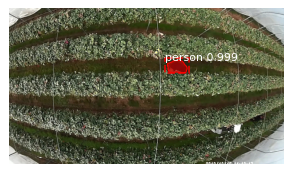

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


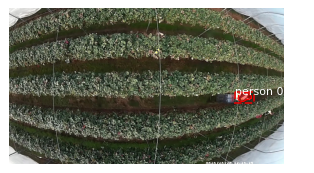

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


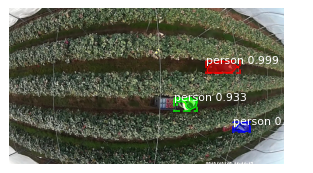

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


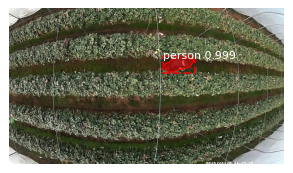

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


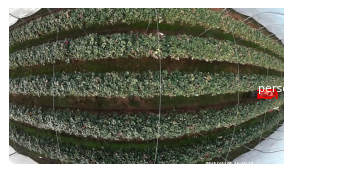

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


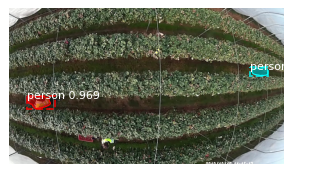

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



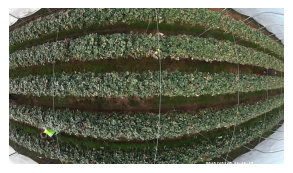

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


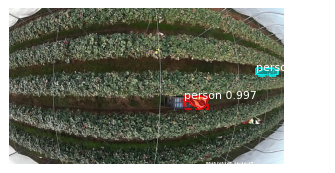

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


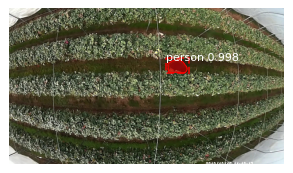

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


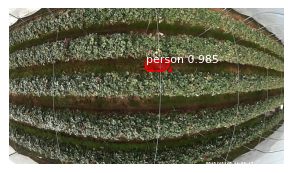

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


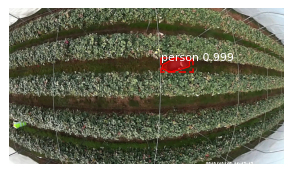

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


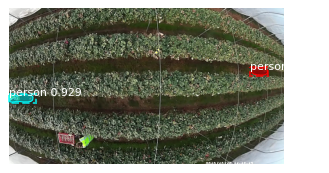

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


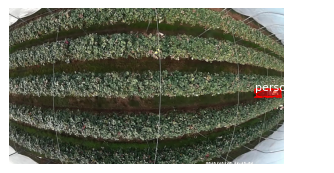

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


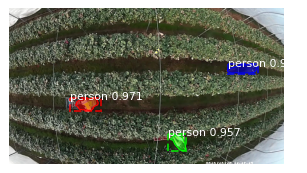

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


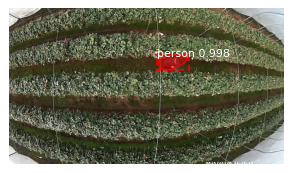

Processing 1 images
image                    shape: (752, 1330, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1330.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


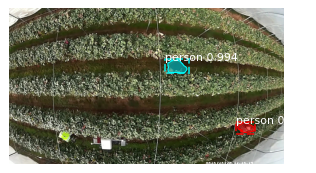

In [24]:
import skimage
real_test_dir = '/home/abhishesh01/video_segmentation/workforJUNE2020/datasets/mask_rcnn_dataset/dataset/test_images/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

# Try on Video

In [15]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


In [ ]:
   
# We use a K80 GPU with 24GB memory, which can fit 3 images.
batch_size = 1

ROOT_DIR = '/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/' #os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
COCO_MODEL_PATH = '/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/logs/person20200622T2255/mask_rcnn_person_0006' #os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'ezgif.com-gif-maker.mp4'))
try:
    if not os.path.exists(VIDEO_SAVE_DIR):
        os.makedirs(VIDEO_SAVE_DIR)
except OSError:
    print ('Error: Creating directory of data')
frames = []
frame_count = 0
# these 2 lines can be removed if you dont have a 1080p camera.
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while True:
    ret, frame = capture.read()
    # Bail out when the video file ends
    if not ret:
        break

    # Save each frame of the video to a list
    frame_count += 1
    frames.append(frame)
    print('frame_count :{0}'.format(frame_count))
    if len(frames) == batch_size:
        results = model.detect(frames, verbose=0)
        print('Predicted')
        for i, item in enumerate(zip(frames, results)):
            frame = item[0]
            r = item[1]
            frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'])
#             visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset_val.class_names, r['scores'], figsize=(5,5))
            name = '{0}.jpg'.format(frame_count + i - batch_size)
            name = os.path.join(VIDEO_SAVE_DIR, name)
            cv2.imwrite(name, frame)
            print('writing to file:{0}'.format(name))
        # Clear the frames array to start the next batch
        frames = []

capture.release()


frame_count :1
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/0.jpg
frame_count :2
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/1.jpg
frame_count :3
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/2.jpg
frame_count :4
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/3.jpg
frame_count :5
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/4.jpg
frame_count :6
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/5.jpg
frame_count :7
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/6.jpg
frame_count :8
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/vi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/63.jpg
frame_count :65
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/64.jpg
frame_count :66
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/65.jpg
frame_count :67
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/66.jpg
frame_count :68
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/67.jpg
frame_count :69
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/68.jpg
frame_count :70
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/69.jpg
frame_count :71
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/vid

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/127.jpg
frame_count :129
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/128.jpg
frame_count :130
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/129.jpg
frame_count :131
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/130.jpg
frame_count :132
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/131.jpg
frame_count :133
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/132.jpg
frame_count :134
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/133.jpg
frame_count :135
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/190.jpg
frame_count :192
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/191.jpg
frame_count :193
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/192.jpg
frame_count :194
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/193.jpg
frame_count :195
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/194.jpg
frame_count :196
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/195.jpg
frame_count :197
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/196.jpg
frame_count :198
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/253.jpg
frame_count :255
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/254.jpg
frame_count :256
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/255.jpg
frame_count :257
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/256.jpg
frame_count :258
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/257.jpg
frame_count :259
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/258.jpg
frame_count :260
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/259.jpg
frame_count :261
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/316.jpg
frame_count :318
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/317.jpg
frame_count :319
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/318.jpg
frame_count :320
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/319.jpg
frame_count :321
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/320.jpg
frame_count :322
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/321.jpg
frame_count :323
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/322.jpg
frame_count :324
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/379.jpg
frame_count :381
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/380.jpg
frame_count :382
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/381.jpg
frame_count :383
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/382.jpg
frame_count :384
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/383.jpg
frame_count :385
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/384.jpg
frame_count :386
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/385.jpg
frame_count :387
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/442.jpg
frame_count :444
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/443.jpg
frame_count :445
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/444.jpg
frame_count :446
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/445.jpg
frame_count :447
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/446.jpg
frame_count :448
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/447.jpg
frame_count :449
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi_Mask_RCNN/videos/save/448.jpg
frame_count :450
Predicted
writing to file:/home/abhishesh01/video_segmentation/workforJUNE2020/abhi

In [ ]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'ezgif.com-gif-maker.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

def make_video(outvid, images=None, fps=25, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

In [ ]:
ls -alh ./videos/